# DL PROJECT

## Implementing InceptionResNetV2 and RestNet50





In [ ]:
import tensorflow as tf 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import array_to_img
# from sklearn.model_selection import train_test_split
# from PIL import Image
# import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

# from tqdm import tqdm, tqdm_notebook
# from colorama import Fore
# import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
# import time
# from sklearn.decomposition import PCA
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# import lightgbm as lgb
# import xgboost as xgb
# !pip install livelossplot
# import livelossplot
# from livelossplot import PlotLossesKeras
import warnings
warnings.filterwarnings('ignore')
print("All modules have been imported")

All modules have been imported


## DIABETIC RETINOPATHY DETECTION

In [ ]:
# copy the weights and configurations for the pre-trained models
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

mkdir: cannot create directory ‘/root/.keras’: File exists
cp: cannot stat '../input/keras-pretrained-models/*notop*': No such file or directory
cp: cannot stat '../input/keras-pretrained-models/imagenet_class_index.json': No such file or directory


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob

%matplotlib inline 

#### Data set of 10000 images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
base_image_dir = os.path.join('.', '/content/drive/MyDrive/Sample_data_10000')
df = pd.read_csv(os.path.join('/content/drive/MyDrive/trainLabels_cropped.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset

df = df[df['exists']]
print(df[df['exists']])
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True)#shuffle dataframe
df['level'] = df['level'].astype(str)
df.head(10)

       Unnamed: 0  Unnamed: 0.1        image  level  \
0               0             0      10_left      0   
1               1             1     10_right      0   
2               2             2      13_left      0   
3               3             3     13_right      0   
4               4             4      15_left      1   
...           ...           ...          ...    ...   
10183       10183         10190   12838_left      0   
10184       10184         10191  12838_right      0   
10185       10185         10192   12839_left      2   
10186       10186         10193  12839_right      2   
10187       10187         10194   12842_left      0   

                                                    path  exists  
0      /content/drive/MyDrive/Sample_data_10000/10_le...    True  
1      /content/drive/MyDrive/Sample_data_10000/10_ri...    True  
2      /content/drive/MyDrive/Sample_data_10000/13_le...    True  
3      /content/drive/MyDrive/Sample_data_10000/13_ri...    True  
4   

,Unnamed: 0,Unnamed: 0.1,level,path
0,8369,8375,2,/content/drive/MyDrive/Sample_data_10000/10501...
1,5393,5397,0,/content/drive/MyDrive/Sample_data_10000/6796_...
2,8391,8397,0,/content/drive/MyDrive/Sample_data_10000/10534...
3,6285,6289,2,/content/drive/MyDrive/Sample_data_10000/7905_...
4,3470,3474,0,/content/drive/MyDrive/Sample_data_10000/4335_...
5,4520,4524,0,/content/drive/MyDrive/Sample_data_10000/5700_...
6,7426,7430,0,/content/drive/MyDrive/Sample_data_10000/9340_...
7,4176,4180,0,/content/drive/MyDrive/Sample_data_10000/5241_...
8,4800,4804,0,/content/drive/MyDrive/Sample_data_10000/6024_...
9,3614,3618,1,/content/drive/MyDrive/Sample_data_10000/4527_...


In [ ]:
df['level'].value_counts()

0    7396
2    6173
1    6073
3    5941
4    5935
Name: level, dtype: int64

# Preprocessing

## Distribution of Eye and Severity

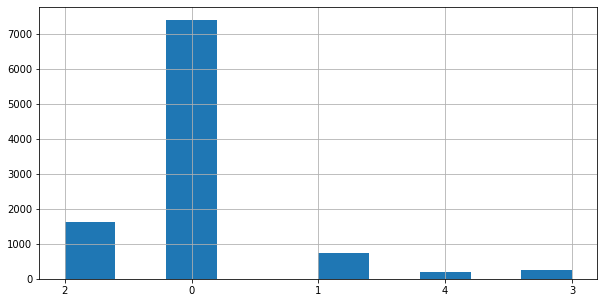

In [ ]:
df['level'].hist(figsize = (10, 5))

In [ ]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

## Split Data into Training and Validation

2038

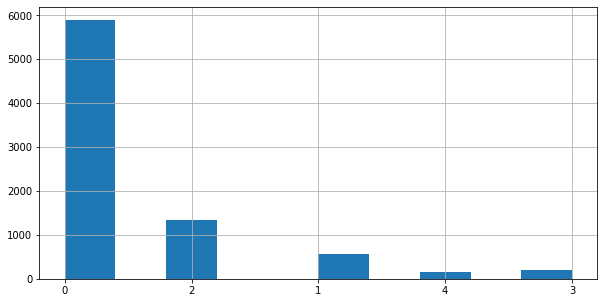

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set
train_df['level'].hist(figsize = (10, 5))
len(val_df)

## Balancing the distribution in the Training set

New Data Size: 29480 Old Size: 8150


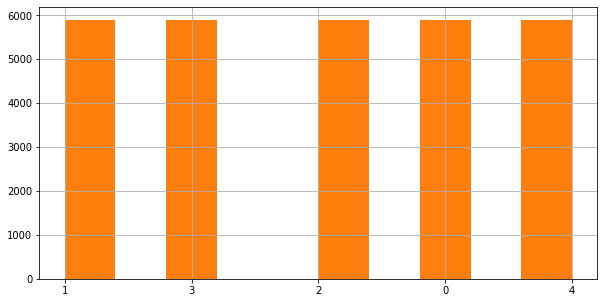

In [ ]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [ ]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

31518

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip = True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

In [ ]:
x_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=".",
        x_col="path",
        y_col="level",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')
x_test = test_datagen.flow_from_dataframe(
        val_df,
        x_col="path",
        y_col="level",
        directory=".",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 29620 validated image filenames belonging to 5 classes.
Found 2038 validated image filenames belonging to 5 classes.


In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
t_x, t_y = next(x_train)

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
from keras.layers import BatchNormalization
from keras import Sequential 
from keras.layers import  Activation

# InceptionResNet V2




In [ ]:
# Initializing a Sequential model:


model = Sequential()
model.add(InceptionResNetV2(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet'))
model.trainable = False
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Creating an output layer
model.add(Dense(units= 5, activation='softmax'))

from keras.metrics import top_k_categorical_accuracy

def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy', top_2_accuracy])
model.summary()

219055592/219055592 [==============================] - 10s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 55296)             0         
                                                                 
 batch_normalization_203 (Ba  (None, 55296)            221184    
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 64)                3539008   
                                                                 
 batch_normalization_204 (Ba  (None, 64)               256       
 tchNormalization)                                    

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
filepath = "dr-detector.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor="val_top2_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

earlystop = EarlyStopping(monitor='val_categorical_accuracy',
                          verbose=1, 
                          min_delta=0, 
                          patience=15, 
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              verbose=1,
                              factor=0.2, 
                              patience=6, 
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0.001)


callbacks = [checkpoint, earlystop, reduce_lr]

In [ ]:
history = model.fit(
        x_train,
        steps_per_epoch=x_train.samples // 64,
        epochs=5,
        validation_data=x_test,
        validation_steps=x_test.samples // 64,
        callbacks=callbacks)
model.save_weights("dr_messidor.h5")

Epoch 1/5
463/463 [==============================] - ETA: 0s - loss: 2.1608 - categorical_accuracy: 0.1998 - top_2_accuracy: 0.3969

463/463 [==============================] - 3952s 8s/step - loss: 2.1608 - categorical_accuracy: 0.1998 - top_2_accuracy: 0.3969 - val_loss: 1.5997 - val_categorical_accuracy: 0.0302 - val_top_2_accuracy: 0.7056 - lr: 0.0010
Epoch 2/5
463/463 [==============================] - ETA: 0s - loss: 2.1669 - categorical_accuracy: 0.2007 - top_2_accuracy: 0.3963

463/463 [==============================] - 1407s 3s/step - loss: 2.1669 - categorical_accuracy: 0.2007 - top_2_accuracy: 0.3963 - val_loss: 1.6089 - val_categorical_accuracy: 0.0333 - val_top_2_accuracy: 0.6804 - lr: 0.0010
Epoch 3/5
463/463 [==============================] - ETA: 0s - loss: 2.1517 - categorical_accuracy: 0.1964 - top_2_accuracy: 0.3997

463/463 [==============================] - 882s 2s/step - loss: 2.1517 - categorical_accuracy: 0.1964 - top_2_accuracy: 0.3997 - val_loss: 1.5969 - val_categorical_accuracy: 0.0232 - val_top_2_accuracy: 0.6895 - lr: 0.0010
Epoch 4/5
463/463 [==============================] - ETA: 0s - loss: 2.1524 - categorical_accuracy: 0.2003 - top_2_accuracy: 0.3952

463/463 [==============================] - 640s 1s/step - loss: 2.1524 - categorical_accuracy: 0.2003 - top_2_accuracy: 0.3952 - val_loss: 1.6165 - val_categorical_accuracy: 0.0312 - val_top_2_accuracy: 0.6573 - lr: 0.0010
Epoch 5/5
463/463 [==============================] - ETA: 0s - loss: 2.1503 - categorical_accuracy: 0.1969 - top_2_accuracy: 0.4033

463/463 [==============================] - 534s 1s/step - loss: 2.1503 - categorical_accuracy: 0.1969 - top_2_accuracy: 0.4033 - val_loss: 1.6017 - val_categorical_accuracy: 0.0252 - val_top_2_accuracy: 0.6784 - lr: 0.0010


In [ ]:
train_score = model.evaluate(x_train)
test_score = model.evaluate(x_test)

64/64 [==============================] - 73s 1s/step - loss: 1.6018 - categorical_accuracy: 0.0319 - top_2_accuracy: 0.6869


In [ ]:
print("Final training categorical accuracy = {:.2f} , Final validation categorical accuracy = {:.2f}".format(train_score[1]*100, test_score[1]*100))
print("Final training Top 2 accuracy = {:.2f} , Final validation Top 2 accuracy = {:.2f}".format(train_score[2]*100, test_score[2]*100))
print("Final training loss = {:.2f} , Final validation loss = {:.2f}".format(train_score[0], test_score[0]))

Final training categorical accuracy = 19.62 , Final validation categorical accuracy = 3.19
Final training Top 2 accuracy = 40.07 , Final validation Top 2 accuracy = 68.69
Final training loss = 1.67 , Final validation loss = 1.60


In [ ]:
history.history

{'loss': [2.1608269214630127,
  2.166865587234497,
  2.1517422199249268,
  2.1524479389190674,
  2.150306224822998],
 'categorical_accuracy': [0.1997973620891571,
  0.20067544281482697,
  0.19640928506851196,
  0.20025648176670074,
  0.1968817561864853],
 'top_2_accuracy': [0.3968929350376129,
  0.3962850272655487,
  0.3997030258178711,
  0.395180881023407,
  0.4033477306365967],
 'val_loss': [1.5997220277786255,
  1.608885645866394,
  1.5969200134277344,
  1.6164957284927368,
  1.6017173528671265],
 'val_categorical_accuracy': [0.030241934582591057,
  0.033266130834817886,
  0.02318548411130905,
  0.03125,
  0.02520161308348179],
 'val_top_2_accuracy': [0.7056451439857483,
  0.680443525314331,
  0.6895161271095276,
  0.6572580933570862,
  0.6784273982048035],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001]}

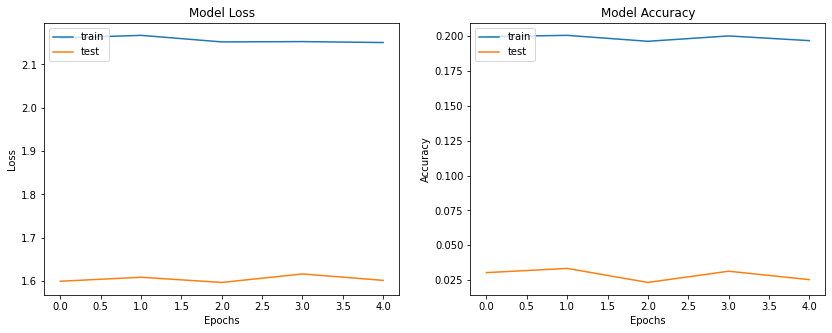

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

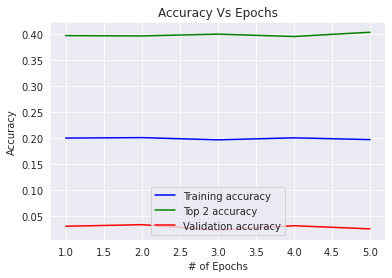

<Figure size 432x288 with 0 Axes>

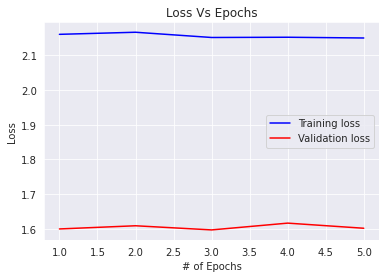

In [ ]:
import seaborn as sb

sb.set_style("darkgrid")

Categorical_Acuracy = history.history['categorical_accuracy']
Top_2_Accuracy = history.history['top_2_accuracy']
Val_Categorical_Accuracy = history.history['val_categorical_accuracy']

Loss = history.history['loss']
Val_Loss = history.history['val_loss']

Epochs = range(1, len(Categorical_Acuracy) + 1)

#Train and validation accuracy
plt.plot(Epochs, Categorical_Acuracy, 'b', label='Training accuracy')
plt.plot(Epochs, Top_2_Accuracy, 'g', label='Top 2 accuracy')
plt.plot(Epochs, Val_Categorical_Accuracy, 'r', label='Validation accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Epochs')
plt.legend()

plt.figure()

plt.show()



print("\n\n")



#Train and validation loss



plt.plot(Epochs, Loss, 'b', label='Training loss')

plt.plot(Epochs, Val_Loss, 'r', label='Validation loss')

plt.xlabel('# of Epochs')

plt.ylabel('Loss')

plt.title('Loss Vs Epochs')

plt.legend()



plt.show()

928/928 [==============================] - 857s 921ms/step
Confusion Matrix
[[ 141    2   43    0 5751]
 [ 112    3   21    0 5801]
 [ 135    3   34    0 5765]
 [ 143    0   41    0 5753]
 [ 140    0   35    0 5762]]
Classification Report
              precision    recall  f1-score   support

           0       0.21      0.02      0.04      5937
           1       0.38      0.00      0.00      5937
           2       0.20      0.01      0.01      5937
           3       0.00      0.00      0.00      5937
           4       0.20      0.97      0.33      5937

    accuracy                           0.20     29685
   macro avg       0.20      0.20      0.08     29685
weighted avg       0.20      0.20      0.08     29685



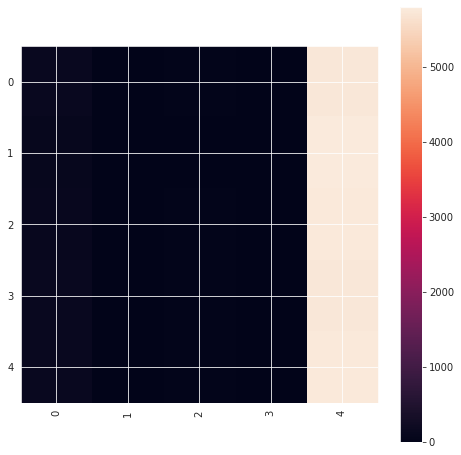

In [ ]:
y_pred = model.predict(x_train)
y_pred = np.argmax(y_pred, axis=1)
class_labels = x_test.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(x_train.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(x_train.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
y_pred.size

29685

In [ ]:
y_test = x_train.classes

# RESTNet50

In [ ]:
# Initializing a Sequential model:


model1 = Sequential()
model1.add(ResNet50(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet'))
model1.trainable = False
model1.add(Flatten())
model1.add(BatchNormalization())
model1.add(Dense(64,kernel_initializer='he_uniform'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(128,kernel_initializer='he_uniform'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(256,kernel_initializer='he_uniform'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(64,kernel_initializer='he_uniform'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(32,kernel_initializer='he_uniform'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
# Creating an output layer
model1.add(Dense(units= 5, activation='softmax'))

from keras.metrics import top_k_categorical_accuracy

def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy', top_2_accuracy])
model1.summary()

94765736/94765736 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 batch_normalization_209 (Ba  (None, 131072)           524288    
 tchNormalization)                                               
                                                                 
 dense_6 (Dense)             (None, 64)                8388672   
                                                                 
 batch_normalization_210 (Ba  (None, 64)               256       
 tchNormalization)                                               
                                                       

In [ ]:
history1 = model1.fit(
        x_train,
        steps_per_epoch=x_train.samples // 64,
        epochs=5,
        validation_data=x_test,
        validation_steps=x_test.samples // 64,
        callbacks=callbacks)
model1.save_weights("dr_messidor.h5")

Epoch 1/5
460/460 [==============================] - ETA: 0s - loss: 2.2272 - categorical_accuracy: 0.1983 - top_2_accuracy: 0.3983

460/460 [==============================] - 3886s 8s/step - loss: 2.2272 - categorical_accuracy: 0.1983 - top_2_accuracy: 0.3983 - val_loss: 1.8184 - val_categorical_accuracy: 0.0353 - val_top_2_accuracy: 0.0827 - lr: 0.0010
Epoch 2/5
460/460 [==============================] - ETA: 0s - loss: 2.2209 - categorical_accuracy: 0.1982 - top_2_accuracy: 0.4025

460/460 [==============================] - 1322s 3s/step - loss: 2.2209 - categorical_accuracy: 0.1982 - top_2_accuracy: 0.4025 - val_loss: 1.8484 - val_categorical_accuracy: 0.0433 - val_top_2_accuracy: 0.0867 - lr: 0.0010
Epoch 3/5
460/460 [==============================] - ETA: 0s - loss: 2.2153 - categorical_accuracy: 0.2061 - top_2_accuracy: 0.4014

460/460 [==============================] - 806s 2s/step - loss: 2.2153 - categorical_accuracy: 0.2061 - top_2_accuracy: 0.4014 - val_loss: 1.8319 - val_categorical_accuracy: 0.0423 - val_top_2_accuracy: 0.0978 - lr: 0.0010
Epoch 4/5
460/460 [==============================] - ETA: 0s - loss: 2.2210 - categorical_accuracy: 0.1996 - top_2_accuracy: 0.3977

460/460 [==============================] - 629s 1s/step - loss: 2.2210 - categorical_accuracy: 0.1996 - top_2_accuracy: 0.3977 - val_loss: 1.8430 - val_categorical_accuracy: 0.0363 - val_top_2_accuracy: 0.0867 - lr: 0.0010
Epoch 5/5
460/460 [==============================] - ETA: 0s - loss: 2.2224 - categorical_accuracy: 0.1955 - top_2_accuracy: 0.3911

460/460 [==============================] - 538s 1s/step - loss: 2.2224 - categorical_accuracy: 0.1955 - top_2_accuracy: 0.3911 - val_loss: 1.8579 - val_categorical_accuracy: 0.0413 - val_top_2_accuracy: 0.0817 - lr: 0.0010


In [ ]:
train_score1 = model1.evaluate(x_train)
test_score1 = model1.evaluate(x_test)

64/64 [==============================] - 72s 1s/step - loss: 1.8559 - categorical_accuracy: 0.0378 - top_2_accuracy: 0.0859


In [ ]:
print("Final training categorical accuracy = {:.2f} , Final validation categorical accuracy = {:.2f}".format(train_score1[1]*100, test_score1[1]*100))
print("Final training Top 2 accuracy = {:.2f} , Final validation Top 2 accuracy = {:.2f}".format(train_score1[2]*100, test_score1[2]*100))
print("Final training loss = {:.2f} , Final validation loss = {:.2f}".format(train_score1[0], test_score1[0]))

Final training categorical accuracy = 20.48 , Final validation categorical accuracy = 3.78
Final training Top 2 accuracy = 40.42 , Final validation Top 2 accuracy = 8.59
Final training loss = 1.66 , Final validation loss = 1.86


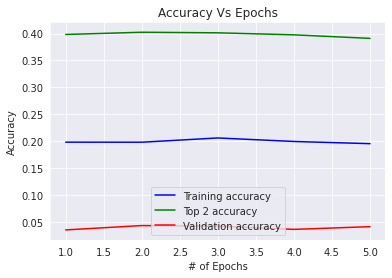

<Figure size 432x288 with 0 Axes>

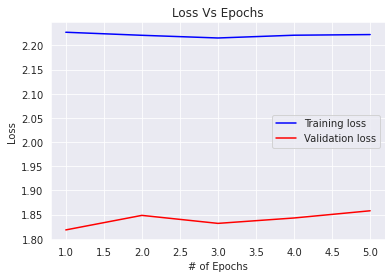

In [ ]:
import seaborn as sb

sb.set_style("darkgrid")

Categorical_Acuracy1 = history1.history['categorical_accuracy']
Top_2_Accuracy1 = history1.history['top_2_accuracy']
Val_Categorical_Accuracy1 = history1.history['val_categorical_accuracy']

Loss1 = history1.history['loss']
Val_Loss1 = history1.history['val_loss']

Epochs1 = range(1, len(Categorical_Acuracy1) + 1)

#Train and validation accuracy
plt.plot(Epochs1, Categorical_Acuracy1, 'b', label='Training accuracy')
plt.plot(Epochs1, Top_2_Accuracy1, 'g', label='Top 2 accuracy')
plt.plot(Epochs1, Val_Categorical_Accuracy1, 'r', label='Validation accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Epochs')
plt.legend()

plt.figure()

plt.show()



print("\n\n")



#Train and validation loss



plt.plot(Epochs1, Loss1, 'b', label='Training loss')

plt.plot(Epochs1, Val_Loss1, 'r', label='Validation loss')

plt.xlabel('# of Epochs')

plt.ylabel('Loss')

plt.title('Loss Vs Epochs')

plt.legend()



plt.show()

922/922 [==============================] - 851s 921ms/step
Confusion Matrix
[[  24 1885    1 2249 1737]
 [  31 1864    0 2263 1738]
 [  37 1949    0 2258 1652]
 [  28 1834    1 2248 1785]
 [  34 1869    2 2288 1703]]
Classification Report
              precision    recall  f1-score   support

           0       0.16      0.00      0.01      5896
           1       0.20      0.32      0.24      5896
           2       0.00      0.00      0.00      5896
           3       0.20      0.38      0.26      5896
           4       0.20      0.29      0.23      5896

    accuracy                           0.20     29480
   macro avg       0.15      0.20      0.15     29480
weighted avg       0.15      0.20      0.15     29480



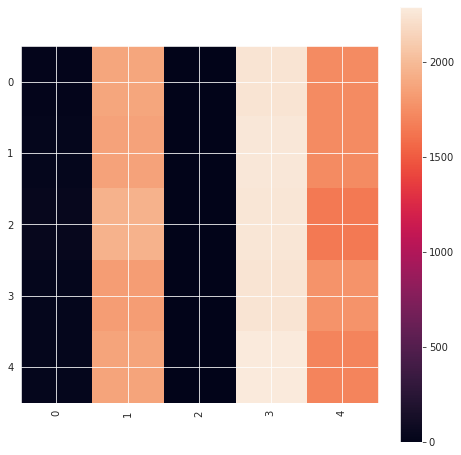

In [ ]:
y_pred1 = model1.predict(x_train)
y_pred1 = np.argmax(y_pred1, axis=1)
class_labels1 = x_test.class_indices
class_labels1 = {v:k for k,v in class_labels1.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train1 = confusion_matrix(x_train.classes, y_pred1)
print('Confusion Matrix')
print(cm_train1)
print('Classification Report')
target_names1 = list(class_labels1.values())
print(classification_report(x_train.classes, y_pred1, target_names=target_names1))

plt.figure(figsize=(8,8))
plt.imshow(cm_train1, interpolation='nearest')
plt.colorbar()
tick_mark1 = np.arange(len(target_names1))
_ = plt.xticks(tick_mark1, target_names1, rotation=90)
_ = plt.yticks(tick_mark1, target_names1)